# Задача 2

Подготовка данных

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# specify columns to use
cols_to_use = ['Country', 'Region', 'Population', 'Area (sq. mi.)', 'Net migration', 'Literacy (%)']
# read file as dataframe
data = pd.read_csv('countries of the world.csv', usecols = cols_to_use)

In [3]:
# inspect data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         227 non-null    object
 1   Region          227 non-null    object
 2   Population      227 non-null    int64 
 3   Area (sq. mi.)  227 non-null    int64 
 4   Net migration   224 non-null    object
 5   Literacy (%)    209 non-null    object
dtypes: int64(2), object(4)
memory usage: 10.8+ KB
None


В колонках 'Net migration' и 'Literacy (%)' есть несколько пропущенных значений. Более того, нужный тип данных для этих колонок float.

In [4]:
# create function to covert values into float format
def convert_to_float(x):
    if pd.isna(x):
        return x
    else:
        return float(x.replace(",",'.'))

# apply function to columns
data['Net migration'] = data['Net migration'].apply(convert_to_float)
data['Literacy (%)'] = data['Literacy (%)'].apply(convert_to_float)

# check format again
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         227 non-null    object 
 1   Region          227 non-null    object 
 2   Population      227 non-null    int64  
 3   Area (sq. mi.)  227 non-null    int64  
 4   Net migration   224 non-null    float64
 5   Literacy (%)    209 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 10.8+ KB
None


In [5]:
# adjust numbers
data['Population'] = data['Population']/1000000
data['Area (sq. mi.)'] = data['Area (sq. mi.)']/1000000
# rename columns
data.columns = ['Country', 'Region', 'Population (mil)', 'Area (sq. mi.)/1 mil', 'Net migration',
       'Literacy (%)']

In [6]:
# format string type columns
data['Region'] = data['Region'].apply(lambda x: x.strip())
data['Country'] = data['Country'].apply(lambda x: x.strip())

In [7]:
# check for duplicates
print(data.duplicated().unique())

[False]


In [8]:
print(data.describe())

       Population (mil)  Area (sq. mi.)/1 mil  Net migration  Literacy (%)
count        227.000000            227.000000     224.000000    209.000000
mean          28.740284              0.598227       0.038125     82.838278
std          117.891327              1.790282       4.889269     19.722173
min            0.007026              0.000002     -20.990000     17.600000
25%            0.437624              0.004647      -0.927500     70.600000
50%            4.786994              0.086600       0.000000     92.500000
75%           17.497772              0.441811       0.997500     98.000000
max         1313.973713             17.075200      23.060000    100.000000


Широкий разброс в по населению и площади ожидаем, можно думать, что аномалий в данных нет.

Вопрос 1

In [9]:
# inspect unique regions
print(set(data['Region'].unique()))

{'ASIA (EX. NEAR EAST)', 'OCEANIA', 'BALTICS', 'WESTERN EUROPE', 'SUB-SAHARAN AFRICA', 'NORTHERN AFRICA', 'C.W. OF IND. STATES', 'NORTHERN AMERICA', 'NEAR EAST', 'LATIN AMER. & CARIB', 'EASTERN EUROPE'}


In [10]:
# print result
print('Медианное значение площади стран Океании в квадратных милях: {}'.format(data[data['Region'] == 'OCEANIA']['Area (sq. mi.)/1 mil'].median()*1000000))

Медианное значение площади стран Океании в квадратных милях: 811.0


Вопрос 2

In [11]:
# print result (only among those countries that have not-nun value for literacy)
print(data.sort_values('Literacy (%)').head(10)[['Country', 'Literacy (%)']].reset_index(drop=True))

        Country  Literacy (%)
0         Niger          17.6
1  Burkina Faso          26.6
2  Sierra Leone          31.4
3        Guinea          35.9
4   Afghanistan          36.0
5       Somalia          37.8
6   Gambia, The          40.1
7       Senegal          40.2
8          Iraq          40.4
9         Benin          40.9


Вопрос 3

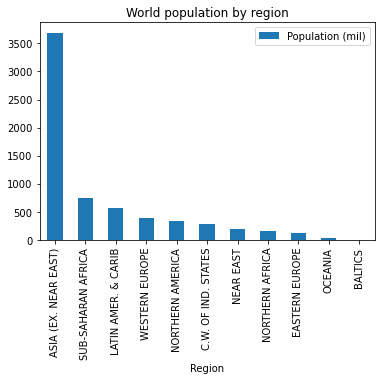

In [12]:
# aggregate data with pivot table and plot results
total_pop = pd.pivot_table(data, 'Population (mil)', 'Region', aggfunc = 'sum').sort_values('Population (mil)', ascending = False)
total_pop.plot(kind = 'bar')
plt.title('World population by region')
plt.show()

Вопрос 4

Как я понимаю, Net migration считается как разность количества иммигрантов и количества эммигрантов, поделенная на среднее количество населения за определенный период и умноженная на 1000. При этом данные представлены для отдельных стран. То есть если мы будем аггрегировать по регионам, мы не сможем посчитать  Net migration для отдельно взятого региона, потому что высока вероятность того, что большая часть миграции происходит в рамках соседних стран.

Поэтому я предлагаю посчитать средний уровень миграции на уровне страны внутри каждого региона. В качестве весов при подсчете среднего возьмем долю населения конкретной страны в общем населении для региона.

При подсчете исключим страны, для которых нет значения Net Migration (их всего 3).

In [13]:
# set index to Region in intitial datframe
data.index = data['Region']
# merge two dataframes on index
data_aug = pd.merge(data, total_pop, left_index=True, right_index=True)
# calculate weights
data_aug['Weights'] = data_aug['Population (mil)_x']/data_aug['Population (mil)_y']
# calculate weighted net migration for each country
data_aug['Weighted NM'] = data_aug['Net migration']*data_aug['Weights']
# calculate average net migration for each region
data_aug.index.names = ['Regions']
print(pd.pivot_table(data_aug, 'Weighted NM', 'Region', aggfunc = 'sum').sort_values('Weighted NM'))

                      Weighted NM
Region                           
BALTICS                 -1.642810
LATIN AMER. & CARIB     -1.534904
EASTERN EUROPE          -0.482372
NORTHERN AFRICA         -0.424852
C.W. OF IND. STATES     -0.227466
ASIA (EX. NEAR EAST)    -0.189787
SUB-SAHARAN AFRICA      -0.102309
NEAR EAST                0.169045
WESTERN EUROPE           1.900726
OCEANIA                  2.718680
NORTHERN AMERICA         3.662115


В среднем для стран Балтийского региона миграционный отток (чистый миграционный приток) составляет примерно 1.65 (-1.65) человек из расчета на 1000 жителей за год. Это самый высокий показатель миграционного оттока.

# Задача 3

Часть 1

In [1]:
# import libraries
from decimal import Decimal
from IPython.display import Image
from sympy.abc import i, k, m, n, x
from sympy import Sum, oo
from math import factorial

1. Допустим, Х - случайная величина, характеризующая количество запусков ГСЧ и N = 4. Тогда Р(Х=0) = Р(Х=1) = Р(Х=2) = Р(Х=3) = 0.

2. Для подсчета вероятности для каждого Х > 4, действует следующая логика (нпример, для Х = 5): а) фиксируем крайнее пятое число (если Х = 5, то пятое число должно отличатсья от уже сгенерированных 4 чисел, причем по определинию задачи среди этих уже сгенерированных 4 чисел должны быть уникальные три числа от 1 до 4); б) посчитаем количество вариантов, удовлетвряющих пункту а): надо разбить 4 "места" на три группы (три уникальных числа) так, чтобы не было пустых групп.

3. Количество вариантов описывается следующей формулой ниже, однако порядок групп важен, поэтому для этой задачи деление на k! не требуется. Для данной задачи n - значение случайной велеичины Х, k - количество уже сгенерированных уникальных чисел до крайнего(или N-1).

4. Полученное количество вариатнов надо домножить на N, так как мы можем выбрать N-1 уникальных чисел из N уникальных чисел N способами. Далее, делим на N^n (общее количество вариантов выбрать N чисел из N уникальных чисел). 

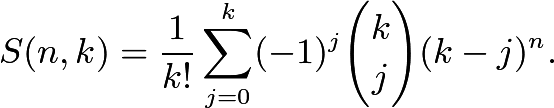

In [15]:
# display formula
Image("stirling.png")

In [2]:
def exp_val(N):
    
    # define binomial coefficient to use in the next function
    def binom(a,b):
        return Decimal(factorial(a)) / (Decimal(factorial(b))*Decimal(factorial(a-b)))
    
    # define function to compute the number of variants as described above
    def stirling_corrected(l,k):
        if l==k:
            return Decimal(factorial(k))
        else:
            s = sum((-1)**(k-j)*binom(k,j)*j**l for j in range(k+1))
            return s
        
    # compute the limit of infinite sequence for expected value using sympy library    
    val = Sum((N*stirling_corrected(n,N-1))/(N**(n+1))*(n+1), (n, N-1, oo)).doit()
        
    return val

In [3]:
# print result for any N
print(exp_val())

3.00000000000000


Для N > 100 подсчет уже не такой быстрый

Часть 2

In [4]:
# import libraries
from random import randrange

In [6]:
def test(N):
    
    # set sum of the number of steps in each game equal to 0
    cummul = 0
    
    # initialize game
    for i in range (1000000):
        # create initial set of integers from 1 to N
        initial = set(list(range(1,N+1)))
        # create empty test set
        test = set()
        count = 0
        # populate test set with numbers till test set equals initial set
        while initial.intersection(test) != initial:
            count += 1
            test.add(randrange(N)+1)
            
        cummul += count
        
    exp_val = cummul/1000000
    
    return(exp_val)

In [7]:
print(test(2))

3.001145
